# Read fasta files using Biopython

## Import Libraries

In [ ]:
!pip install biopython
!pip install kat


In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    matthews_corrcoef
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from joblib import dump, load


SystemError: <built-in function isinstance> returned a result with an exception set

In [ ]:
# Google drive set up for reading files
drive.mount('/content/gdrive')

## Function to save models as joblib files

In [ ]:
def save(model, name):
  path = '/content/gdrive/MyDrive/SMOTE/' + name + '.joblib'

  # Saving the model
  dump(model, path)

  # Loading the model
  loaded_model = load(path)

## Dataframe setup for Training and Testing

In [ ]:
# Read training data from FASTA file
training = '/content/gdrive/MyDrive/IT1244 Group Project/DNA Binding Protein/Train.fasta'
tr_records = SeqIO.parse(training, 'fasta')
tr_data = []

# Extract sequence IDs, labels, and sequences for training
for record in tr_records:
    parts = record.id.split('_')
    seq_id = '_'.join(parts[:-2])
    label = parts[-1]

    tr_data.append({"ID": seq_id, "Label": label, "sequence": str(record.seq)})

# Training data frame
df_training = pd.DataFrame(tr_data)
df_training['Label'] = df_training['Label'].astype(int)
df_training.head()

# Read testing data from FASTA file
testing = '/content/gdrive/MyDrive/IT1244 Group Project/DNA Binding Protein/Test.fasta'
t_records = SeqIO.parse(training, 'fasta')
t_data = []

# Extract sequence IDs, labels, and sequences for testing
for record in t_records:
    parts = record.id.split('_')
    seq_id = '_'.join(parts[:-2])  # Get the ID part
    label = parts[-1]  # Get the label part

    t_data.append({"ID": seq_id, "Label": label, "sequence": str(record.seq)})

# Testing data frame
df_testing = pd.DataFrame(t_data)
df_testing['Label'] = df_training['Label'].astype(int)
df_testing.head()

[link text](https://)Each protein sequence given here consists of amino acids (each character is a representation of one amino acid)
![20 amino acids that make up protein](https://i0.wp.com/www.compoundchem.com/wp-content/uploads/2014/09/20-Common-Amino-Acids.png?fit=2480%2C1754&ssl=1)

In [ ]:
# Standanrd amino acids in a string including 'X' (unknown amino acid)
standard_amino_acids = 'ARNDCEQGHILKMFPSTWYVX'
len(standard_amino_acids)

## Dataframe set up for Training and Testing frequencies

In [ ]:
# Function to compute the frequency of each amino acid in a sequence
def compute_amino_acid_frequencies(sequence):
    counter = Counter(sequence)
    frequencies = {char: counter[char]/len(sequence) for char in standard_amino_acids}
    return frequencies

# Iterate through each row in training and compute the frequencies
for index, row in df_training.iterrows():
    frequencies = compute_amino_acid_frequencies(row['sequence'])

    # Update the dataframe with calculated frequencies for each standard amino acid
    for char in standard_amino_acids:
        df_training.at[index, char] = frequencies[char]

# Display the updated DataFrame for labels 1 and 0
df_training_1 = df_training[df_training['Label'] == 1]
df_training_0 = df_training[df_training['Label'] == 0]

print("DataFrame for Label 1:")
print(df_training_1.head())

print("\nDataFrame for Label 0:")
print(df_training_0.head())


# Compute the frequencies for testing
for index, row in df_testing.iterrows():
    frequencies = compute_amino_acid_frequencies(row['sequence'])
    for char in standard_amino_acids:
        df_testing.at[index, char] = frequencies[char]

print("\nFrequencies for each feature")
df_testing.head()

# Comparison of amino acid distribution between class 0 and class 1

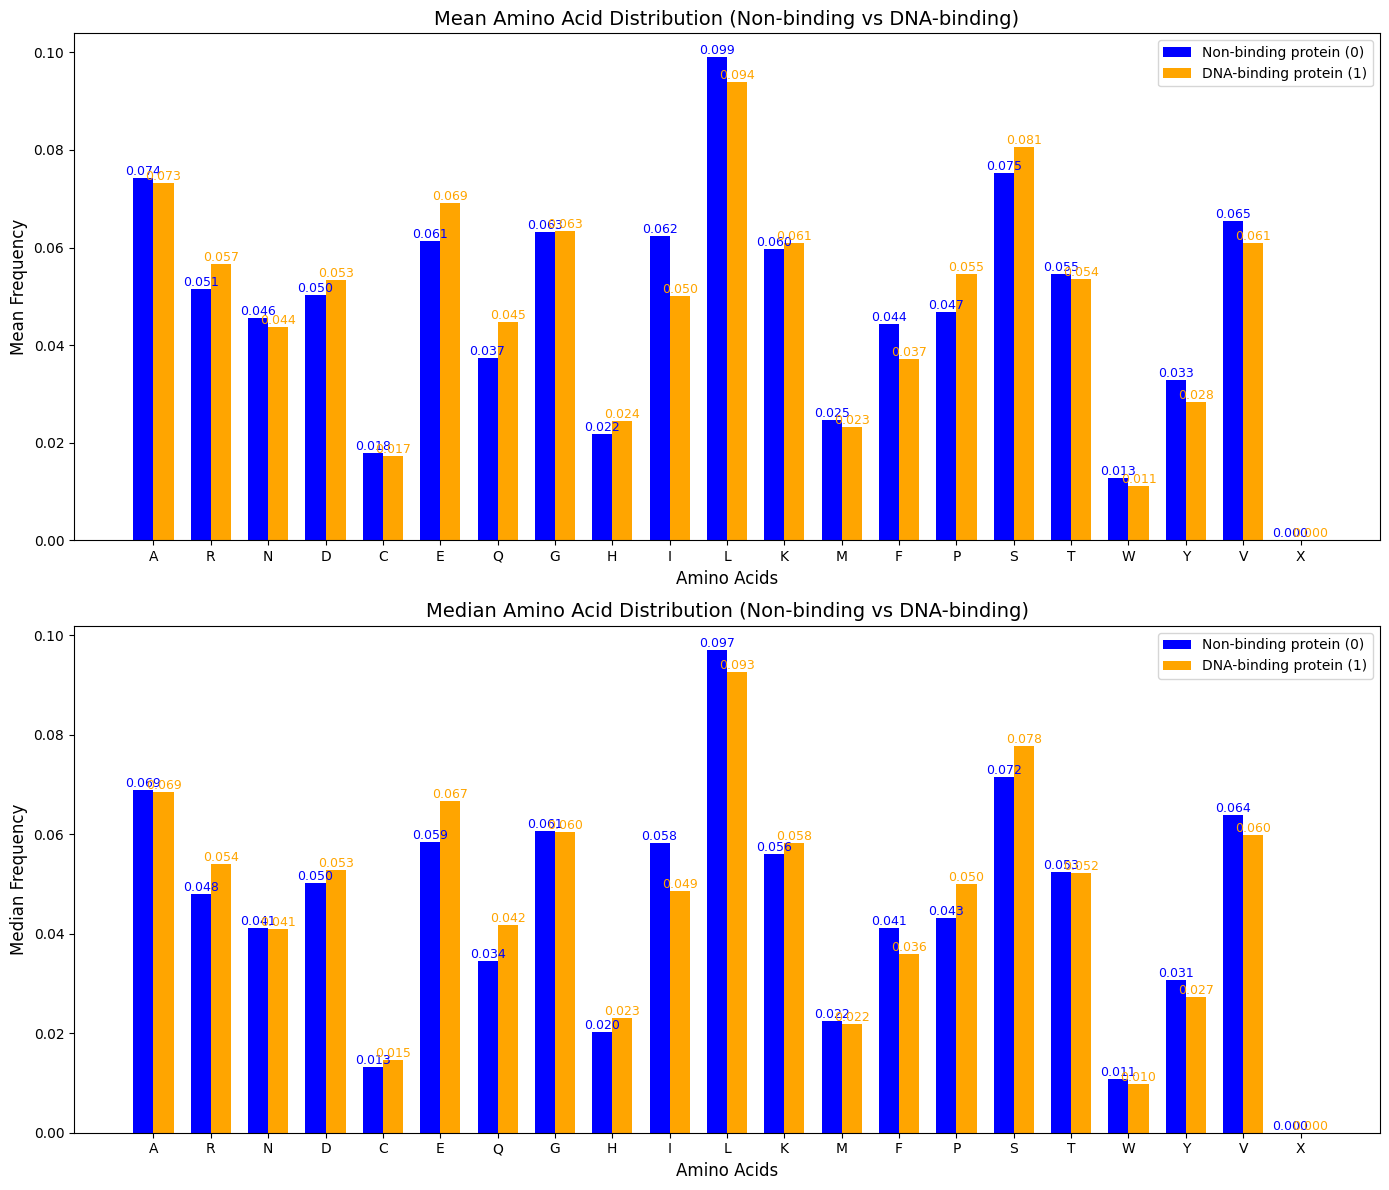

In [ ]:
median_0 = [np.median(df_training_0[aa].dropna()) for aa in standard_amino_acids]
median_1 = [np.median(df_training_1[aa].dropna()) for aa in standard_amino_acids]
mean_0 = [np.mean(df_training_0[aa].dropna()) for aa in standard_amino_acids]
mean_1 = [np.mean(df_training_1[aa].dropna()) for aa in standard_amino_acids]

# Define positions for the amino acids on the x-axis
x = np.arange(len(standard_amino_acids))
bar_width = 0.35  # Width of each bar

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Plot mean frequencies
bars_mean_0 = ax1.bar(x - bar_width / 2, mean_0, bar_width, label='Non-binding protein (0)', color='blue')
bars_mean_1 = ax1.bar(x + bar_width / 2, mean_1, bar_width, label='DNA-binding protein (1)', color='orange')

# Add mean values on top of each bar
for bar in bars_mean_0:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=9, color='blue')

for bar in bars_mean_1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=9, color='orange')

# Set titles, labels, and legend for mean frequency plot
ax1.set_xticks(x)
ax1.set_xticklabels(standard_amino_acids)
ax1.set_xlabel('Amino Acids', fontsize=12)
ax1.set_ylabel('Mean Frequency', fontsize=12)
ax1.set_title('Mean Amino Acid Distribution (Non-binding vs DNA-binding)', fontsize=14)
ax1.legend()

# Plot median frequencies
bars_median_0 = ax2.bar(x - bar_width / 2, median_0, bar_width, label='Non-binding protein (0)', color='blue')
bars_median_1 = ax2.bar(x + bar_width / 2, median_1, bar_width, label='DNA-binding protein (1)', color='orange')

# Add median values on top of each bar
for bar in bars_median_0:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=9, color='blue')

for bar in bars_median_1:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=9, color='orange')

# Set titles, labels, and legend for median frequency plot
ax2.set_xticks(x)
ax2.set_xticklabels(standard_amino_acids)
ax2.set_xlabel('Amino Acids', fontsize=12)
ax2.set_ylabel('Median Frequency', fontsize=12)
ax2.set_title('Median Amino Acid Distribution (Non-binding vs DNA-binding)', fontsize=14)
ax2.legend()

# Adjust layout for a cleaner look
plt.tight_layout()
plt.show()

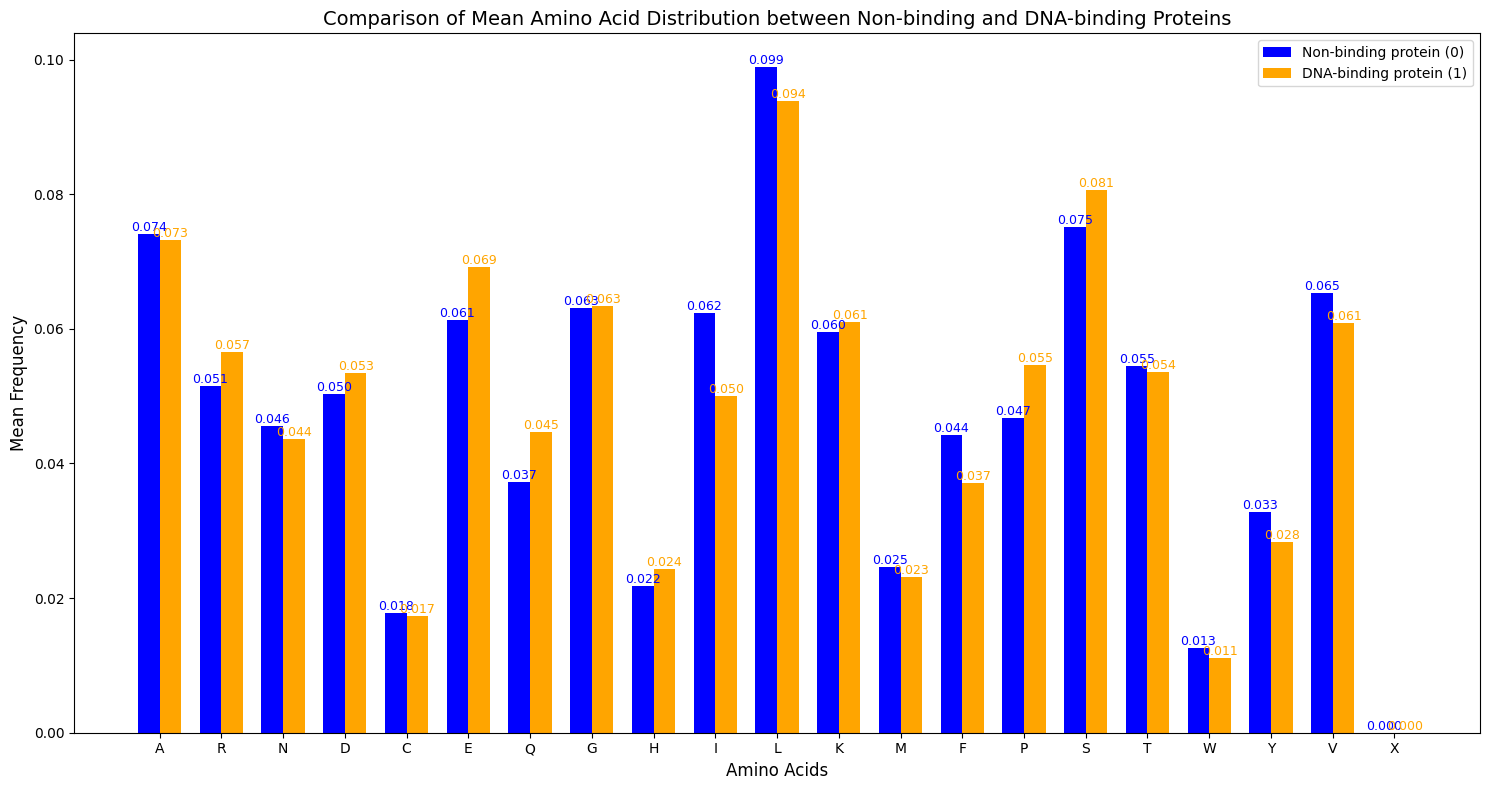

In [ ]:
# Calculate mean frequencies for both label 0 (non-binding) and label 1 (binding) for each amino acid
mean_0 = [np.mean(df_training_0[aa].dropna()) for aa in standard_amino_acids]
mean_1 = [np.mean(df_training_1[aa].dropna()) for aa in standard_amino_acids]

# Create a new figure
plt.figure(figsize=(15, 8))

# Define the positions for the amino acids on the x-axis
x = np.arange(len(standard_amino_acids))

# Bar width
bar_width = 0.35

# Plot bars for label 0 (non-binding) and label 1 (binding)
bars_0 = plt.bar(x - bar_width/2, mean_0, bar_width, label='Non-binding protein (0)', color='blue')
bars_1 = plt.bar(x + bar_width/2, mean_1, bar_width, label='DNA-binding protein (1)', color='orange')

# Add the mean values on top of each bar
for bar in bars_0:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=9, color='blue')

for bar in bars_1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=9, color='orange')

# Set the x-axis ticks and labels (amino acids)
plt.xticks(x, standard_amino_acids)

# Set the labels and title
plt.xlabel('Amino Acids', fontsize=12)
plt.ylabel('Mean Frequency', fontsize=12)
plt.title('Comparison of Mean Amino Acid Distribution between Non-binding and DNA-binding Proteins', fontsize=14)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Compare Median frequency distribution between 2 classes

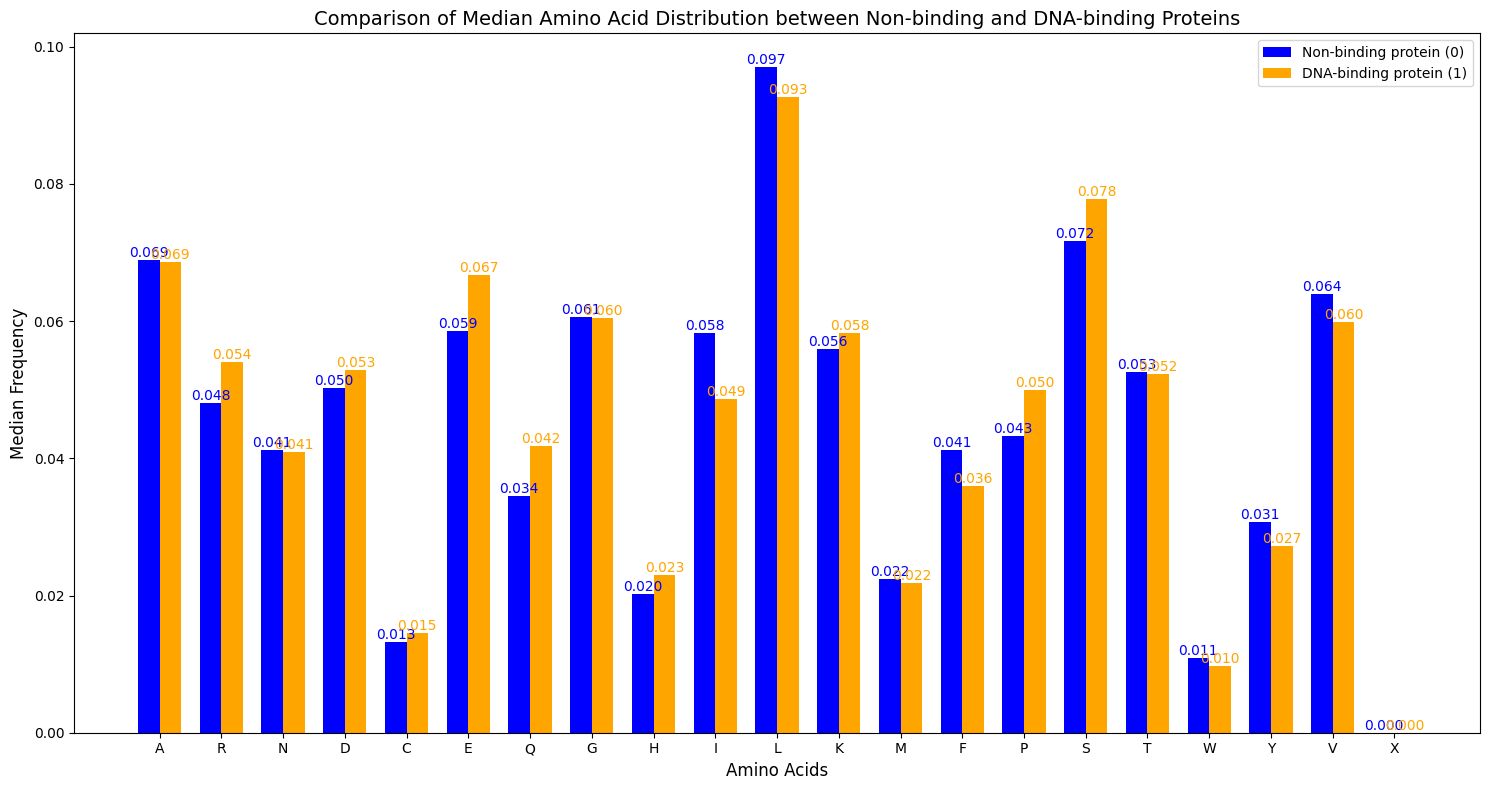

In [ ]:
# Calculate median frequencies for both label 0 (non-binding) and label 1 (binding) for each amino acid
median_0 = [np.median(df_training_0[aa].dropna()) for aa in standard_amino_acids]
median_1 = [np.median(df_training_1[aa].dropna()) for aa in standard_amino_acids]

# Create a new figure
plt.figure(figsize=(15, 8))

# Define the positions for the amino acids on the x-axis
x = np.arange(len(standard_amino_acids))

# Bar width
bar_width = 0.35

# Plot bars for label 0 (non-binding) and label 1 (binding)
bars_0 = plt.bar(x - bar_width/2, median_0, bar_width, label='Non-binding protein (0)', color='blue')
bars_1 = plt.bar(x + bar_width/2, median_1, bar_width, label='DNA-binding protein (1)', color='orange')

# Add the median values on top of each bar
for bar in bars_0:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=10, color='blue')

for bar in bars_1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=10, color='orange')

# Set the x-axis ticks and labels (amino acids)
plt.xticks(x, standard_amino_acids)

# Set the labels and title
plt.xlabel('Amino Acids', fontsize=12)
plt.ylabel('Median Frequency', fontsize=12)
plt.title('Comparison of Median Amino Acid Distribution between Non-binding and DNA-binding Proteins', fontsize=14)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

From both median and mean amino acid distribution, we identify a is small difference ($\leq$ 0.002) between amino acid distribution of A, N, C, G, M, K, T, W, X. Hence, we deduce that the distribution of those amino acids do not affect the classification of a protein. Hence, we will remove those amino acids in our predictive model.

In [ ]:
# Select all columns from the 4th onwards as features
X_train = df_training.iloc[:, 3:].to_numpy()  # Assuming all amino acid frequencies are from the 4th column onwards

# Target labels
y_train = df_training['Label'].to_numpy()  # Ensure y is also a numpy array

X_test = df_testing.iloc[:, 3:].to_numpy()
y_test = df_testing['Label'].to_numpy()

# Amino Acids of similar frequencies are excluded
exclude_cols = ['A', 'N', 'C', 'G', 'M', 'K', 'T', 'W', 'X']

selected = df_training.drop(columns=exclude_cols)
selected.head()

selected_testing = df_testing.drop(columns=exclude_cols)
selected_testing.head()

# Select all columns from the 4th onwards as features
X_train_selected = selected.iloc[:, 3:].to_numpy()  # Assuming all amino acid frequencies are from the 4th column onwards
y_train_selected = selected['Label'].to_numpy()

X_test_selected  = selected_testing.iloc[:,3:].to_numpy()
y_test_selected  = selected_testing['Label'].to_numpy()



## SMOTE to account for imbalace of label_1 and label_0

In [ ]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train) # only for training data

# Helper Functions for metrics

In [ ]:
# Creates a confusion matrix for classifiers
def sketch_confusion_matrix(test_set, predicted_set, name):

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(test_set, predicted_set)

    # Set up the figure size for the plot
    plt.figure(figsize=(8, 6))

    # Create a heatmap to visualize the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non DNA-Binding', 'DNA-Binding'],
                yticklabels=['Non DNA-Binding', 'DNA-Binding'])
    plt.title('Confusion Matrix of ' + name)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Return the confusion matrix
    return conf_matrix

In [ ]:
def plot_roc_curve(y_test, y_probs, name):

    # Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)

    # Calculate the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')  # Label for the x-axis
    plt.ylabel('True Positive Rate')  # Label for the y-axis
    plt.title('RECEIVER OPERATING CHARACTERISTIC of ' + name)
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def get_performance_metrics(test, pred):

    # Accuracy
    accuracy = accuracy_score(test, pred)

    # Precision
    precision = precision_score(test, pred)

    # Recall (sensitivity) of the model
    recall = recall_score(test, pred)

    # F1 score of the model
    f1 = f1_score(test, pred)

    # Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(test, pred)

    # True Negative (TN), False Positive (FP), False Negative (FN), True Positive (TP)
    tn, fp, fn, tp = confusion_matrix(test, pred).ravel()

    # Sensitivity (true positive rate)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Specificity (true negative rate)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    return {
        'Sensitivity': round(sensitivity, 2),
        'Specificity': round(specificity, 2),
        'Accuracy': round(accuracy, 2),
        'Matthews Correlation Coefficient (MCC)': round(mcc, 2),
        'Precision': round(precision, 2),
        'Recall': round(recall, 2),
        'F1 Score': round(f1, 2)
    }


# Logistic Regression Amino Acid Distribution

## Full Amino Acid Disctribution

In [ ]:
# Initialize the logistic regression model
log_reg = LogisticRegression()

In [ ]:
# Train the model
log_reg.fit(X_train, y_train)

# Save model
save(log_reg, "LR_Amino_Acid_Distribution_Full")

# Predict on the test set
y_pred = log_reg.predict(X_test)

# Probabilities for the positive class
y_prob = log_reg.predict_proba(X_test)[:, 1]


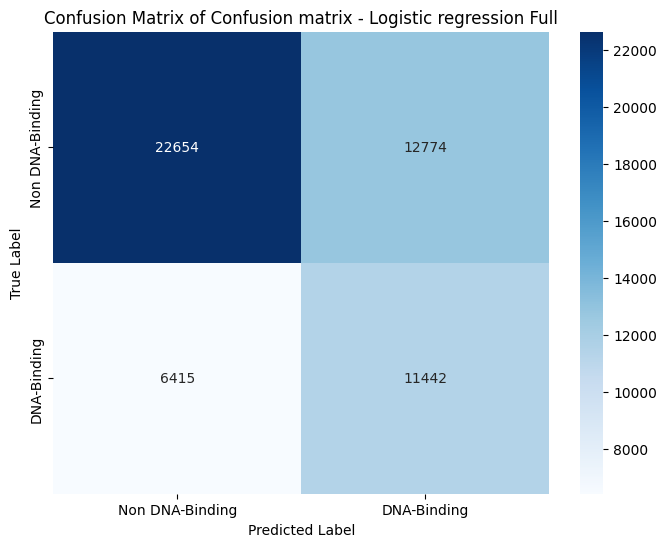

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.64      0.70     35428
           1       0.47      0.64      0.54     17857

    accuracy                           0.64     53285
   macro avg       0.63      0.64      0.62     53285
weighted avg       0.68      0.64      0.65     53285



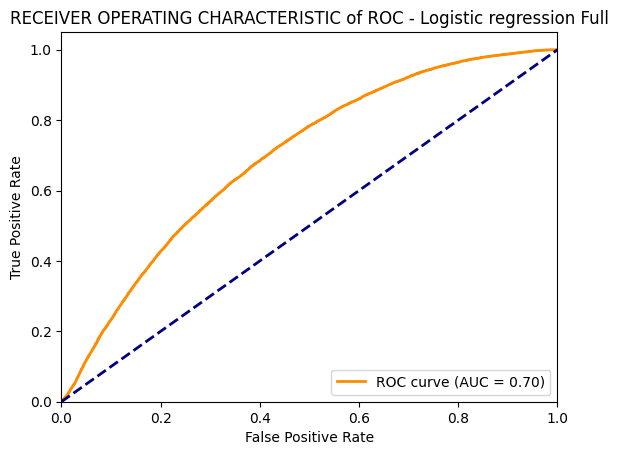

{'Sensitivity': 0.64,
 'Specificity': 0.64,
 'Accuracy': 0.64,
 'Matthews Correlation Coefficient (MCC)': 0.27,
 'Precision': 0.47,
 'Recall': 0.64,
 'F1 Score': 0.54}

In [ ]:
# Confusion matrix, Classification Report, Performance Metrics, ROC, and AUC
conf_matrix = confusion_matrix(y_test, y_pred)
sketch_confusion_matrix(y_test, y_pred, 'Confusion matrix - Logistic regression Full')

print('Classification Report:')
print(classification_report(y_test, y_pred))

plot_roc_curve(y_test, y_prob, 'ROC - Logistic regression Full')

get_performance_metrics(y_test, y_pred)

In [ ]:
# Fitting Logistic Regression Model and model summary
X_train_lr = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_train_lr)
result = logit_model.fit()

print(result.summary())

         Current function value: 0.631961
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                70856
Model:                          Logit   Df Residuals:                    70834
Method:                           MLE   Df Model:                           21
Date:                Sun, 03 Nov 2024   Pseudo R-squ.:                 0.08827
Time:                        13:26:48   Log-Likelihood:                -44778.
converged:                      False   LL-Null:                       -49114.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        734.8772   1069.086      0.687      0.492   -1360.493    2830.247
x1          -740.0221   1069.085     -0.692      0.489   -2835.39

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Selected Amino Acid Distribution

In [ ]:
# Fitting, prediction of labels for test, and probability of label 1
log_reg.fit(X_train_selected, y_train_selected)

# Save model
save(log_reg, "LR_Amino_Acid_Distribution_Selected")

y_pred = log_reg.predict(X_test_selected)
y_prob = log_reg.predict_proba(X_test_selected)[:, 1]

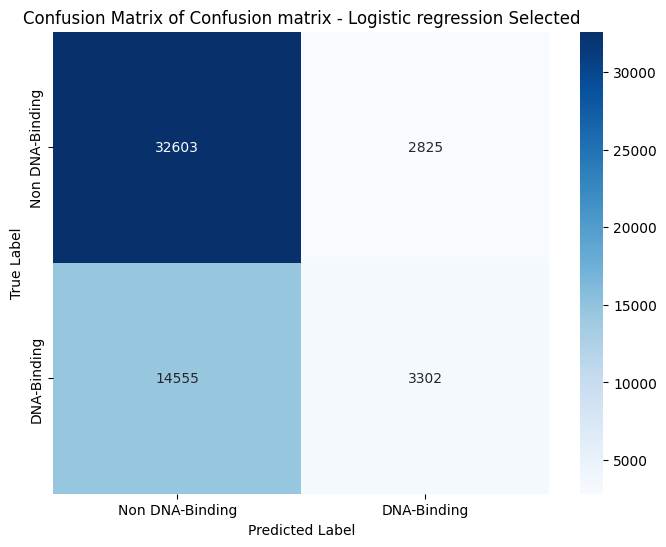

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.92      0.79     35428
           1       0.54      0.18      0.28     17857

    accuracy                           0.67     53285
   macro avg       0.62      0.55      0.53     53285
weighted avg       0.64      0.67      0.62     53285



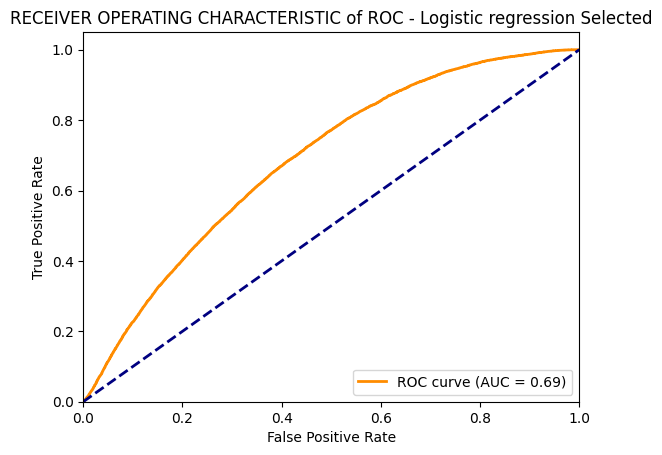

{'Sensitivity': 0.18,
 'Specificity': 0.92,
 'Accuracy': 0.67,
 'Matthews Correlation Coefficient (MCC)': 0.16,
 'Precision': 0.54,
 'Recall': 0.18,
 'F1 Score': 0.28}

In [ ]:
# Confusion matrix, Classification Report, Performance Metrics, ROC, and AUC
conf_matrix = confusion_matrix(y_test_selected, y_pred)
sketch_confusion_matrix(y_test_selected, y_pred, 'Confusion matrix - Logistic regression Selected')

print('Classification Report:')
print(classification_report(y_test_selected, y_pred))

plot_roc_curve(y_test_selected, y_prob, 'ROC - Logistic regression Selected')

get_performance_metrics(y_test_selected, y_pred)

In [ ]:
# Logistic Regression Model and model summary
X_train_lr = sm.add_constant(X_train_selected)
logit_model = sm.Logit(y_train_selected, X_train_lr)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.590189
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                53285
Model:                          Logit   Df Residuals:                    53272
Method:                           MLE   Df Model:                           12
Date:                Sun, 03 Nov 2024   Pseudo R-squ.:                 0.07457
Time:                        13:26:49   Log-Likelihood:                -31448.
converged:                       True   LL-Null:                       -33982.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9726      0.136    -14.552      0.000      -2.238      -1.707
x1             1.1964      0.

# Naive Bayes using Amino Acid Distribution

In [ ]:
# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

## Full Amino Acid Distribution

In [ ]:
# Fitting, prediction of labels for test, and probability of label 1
gnb.fit(X_train, y_train)

# Save model
save(gnb, "NB_Amino_Acid_Distribution_Full")

y_pred = gnb.predict(X_test)
y_prob = gnb.predict_proba(X_test)[:, 1]


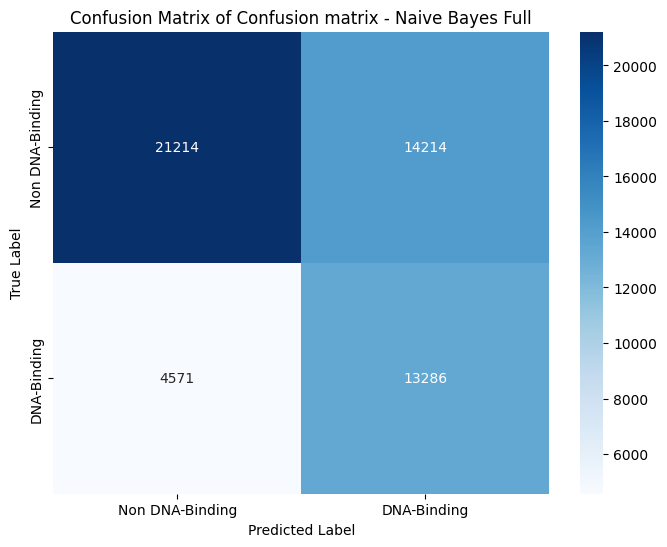

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.60      0.69     35428
           1       0.48      0.74      0.59     17857

    accuracy                           0.65     53285
   macro avg       0.65      0.67      0.64     53285
weighted avg       0.71      0.65      0.66     53285



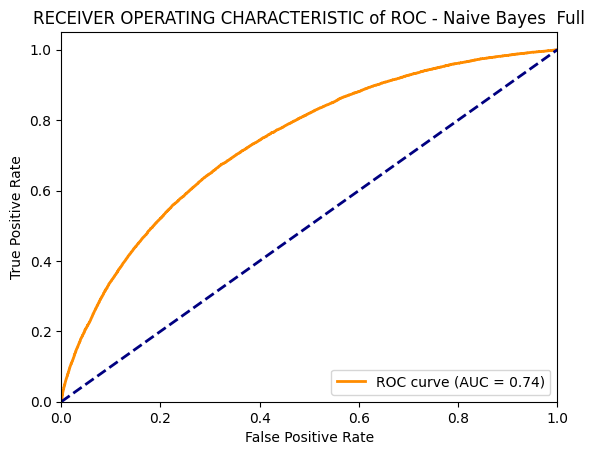

{'Sensitivity': 0.74,
 'Specificity': 0.6,
 'Accuracy': 0.65,
 'Matthews Correlation Coefficient (MCC)': 0.32,
 'Precision': 0.48,
 'Recall': 0.74,
 'F1 Score': 0.59}

In [ ]:
# Confusion matrix, Classification Report, Performance Metrics, ROC, and AUC
conf_matrix = confusion_matrix(y_test, y_pred)
sketch_confusion_matrix(y_test, y_pred, 'Confusion matrix - Naive Bayes Full')

print('Classification Report:')
print(classification_report(y_test, y_pred))

plot_roc_curve(y_test, y_prob, 'ROC - Naive Bayes  Full')

get_performance_metrics(y_test, y_pred)

## Selected Amino Acid Distribution

In [ ]:
# Fitting, prediction of labels for test, and probability of label 1
gnb.fit(X_train_selected, y_train_selected)

# Save model
save(gnb, "NB_Amino_Acid_Distribution_Selected")

y_pred = gnb.predict(X_test_selected)
y_prob = gnb.predict_proba(X_test_selected)[:, 1]


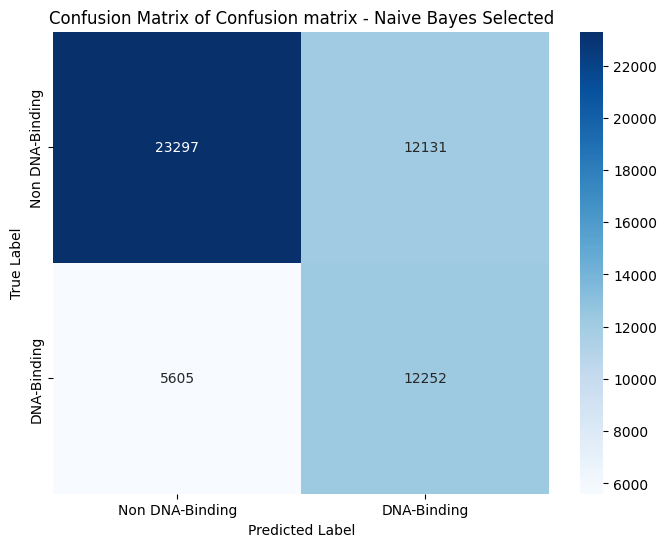

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.66      0.72     35428
           1       0.50      0.69      0.58     17857

    accuracy                           0.67     53285
   macro avg       0.65      0.67      0.65     53285
weighted avg       0.70      0.67      0.68     53285



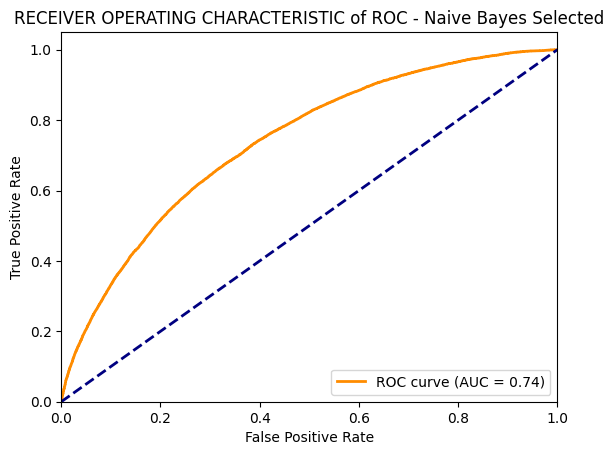

{'Sensitivity': 0.69,
 'Specificity': 0.66,
 'Accuracy': 0.67,
 'Matthews Correlation Coefficient (MCC)': 0.33,
 'Precision': 0.5,
 'Recall': 0.69,
 'F1 Score': 0.58}

In [ ]:
# Confusion matrix, Classification Report, Performance Metrics, ROC, and AUC
conf_matrix = confusion_matrix(y_test_selected, y_pred)
sketch_confusion_matrix(y_test_selected, y_pred, 'Confusion matrix - Naive Bayes Selected')

print('Classification Report:')
print(classification_report(y_test_selected, y_pred))

plot_roc_curve(y_test_selected, y_prob, 'ROC - Naive Bayes Selected')

get_performance_metrics(y_test_selected, y_pred)

# KNN using Amino Acid Distribution

## KNN for Full Amnio Acid Distribution

In [ ]:
# Fitting, prediction of labels for test, and probability of label 1 with the best k
knn = KNeighborsClassifier(n_neighbors=55) # optimal k calculated in Physiochemical Properties.ipynb code
knn.fit(X_train, y_train)

# Save model
save(knn, "KNN_Amino_Acid_Distribution_Full")

y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)[:, 1]


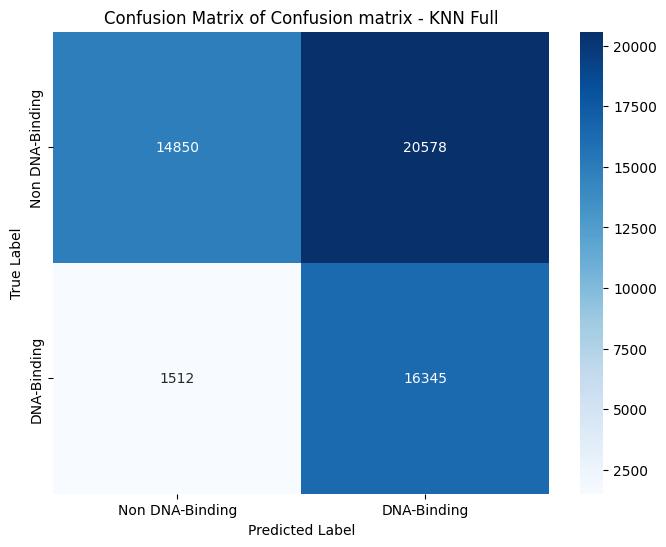

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.42      0.57     35428
           1       0.44      0.92      0.60     17857

    accuracy                           0.59     53285
   macro avg       0.68      0.67      0.59     53285
weighted avg       0.75      0.59      0.58     53285



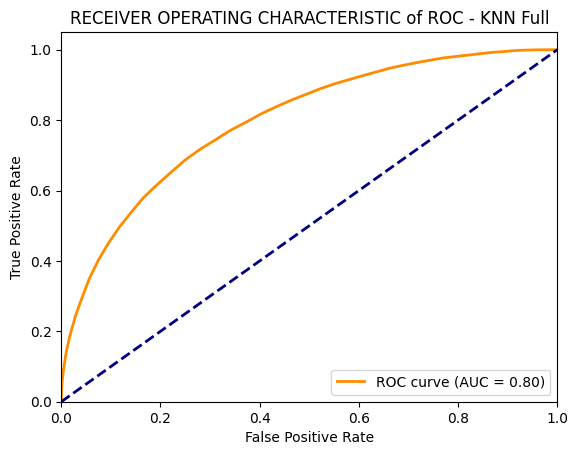

{'Sensitivity': 0.92,
 'Specificity': 0.42,
 'Accuracy': 0.59,
 'Matthews Correlation Coefficient (MCC)': 0.34,
 'Precision': 0.44,
 'Recall': 0.92,
 'F1 Score': 0.6}

In [ ]:
# Confusion matrix, Classification Report, Performance Metrics, ROC, and AUC
conf_matrix = confusion_matrix(y_test, y_pred)
sketch_confusion_matrix(y_test, y_pred, 'Confusion matrix - KNN Full')
print('Classification Report:')
print(classification_report(y_test, y_pred))
plot_roc_curve(y_test, y_prob, 'ROC - KNN Full')
get_performance_metrics(y_test, y_pred)

## KNN for Selected Amino Acid Distribution

In [ ]:
# Fitting, prediction of labels for test, and probability of label 1
knn = KNeighborsClassifier(n_neighbors=187) # optimal k calculated in Physiochemical Properties.ipynb code
knn.fit(X_train_selected, y_train_selected)

# Save model
save(knn, "KNN_Amino_Acid_Distribution_Selected")

y_pred = knn.predict(X_test_selected)
y_prob = knn.predict_proba(X_test_selected)[:, 1]

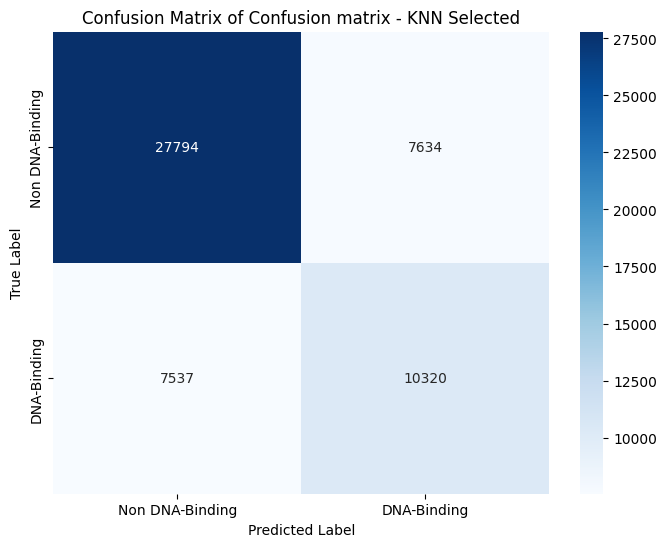

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.79     35428
           1       0.57      0.58      0.58     17857

    accuracy                           0.72     53285
   macro avg       0.68      0.68      0.68     53285
weighted avg       0.72      0.72      0.72     53285



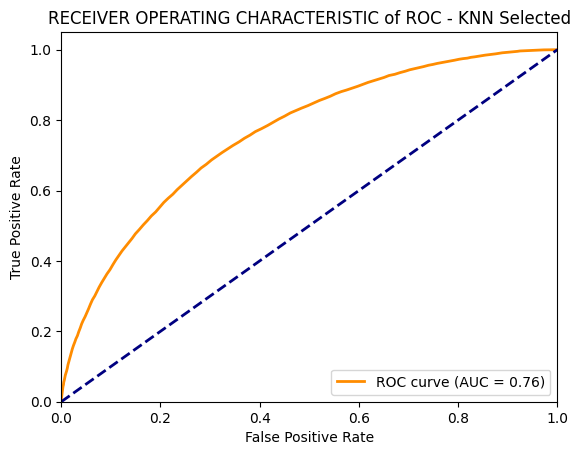

{'Sensitivity': 0.58,
 'Specificity': 0.78,
 'Accuracy': 0.72,
 'Matthews Correlation Coefficient (MCC)': 0.36,
 'Precision': 0.57,
 'Recall': 0.58,
 'F1 Score': 0.58}

In [ ]:
# Confusion matrix, Classification Report, Performance Metrics, ROC, and AUC
conf_matrix = confusion_matrix(y_test_selected, y_pred)
sketch_confusion_matrix(y_test_selected, y_pred, 'Confusion matrix - KNN Selected')
print('Classification Report:')
print(classification_report(y_test_selected, y_pred))
plot_roc_curve(y_test_selected, y_prob, 'ROC - KNN Selected')
get_performance_metrics(y_test_selected, y_pred)

# Decision tree for amino acid distribution

## Full amino acid distribution

In [ ]:
# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=77, class_weight='balanced', max_depth=10) # Max depth set to avoid overfitting

In [ ]:
# Fitting, prediction of labels for test, and probability of label 1
dt_clf.fit(X_train, y_train)

# Save model
save(dt_clf, "DT_Amino_Acid_Distribution_Full")

y_pred = dt_clf.predict(X_test)
y_prob = dt_clf.predict_proba(X_test)[:, 1]

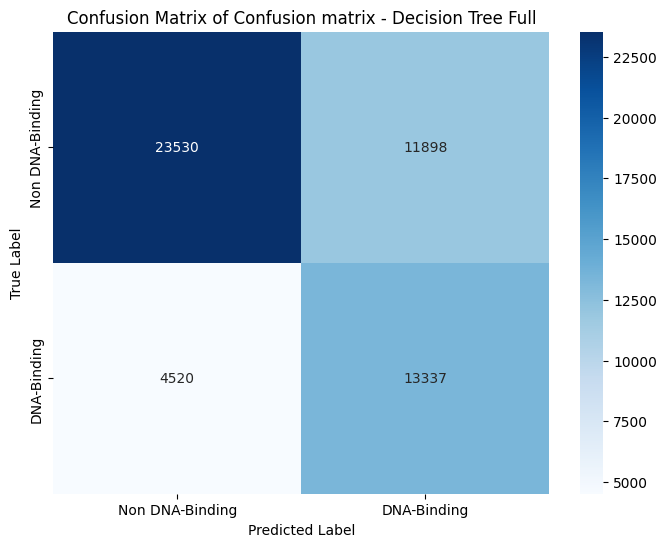

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.66      0.74     35428
           1       0.53      0.75      0.62     17857

    accuracy                           0.69     53285
   macro avg       0.68      0.71      0.68     53285
weighted avg       0.73      0.69      0.70     53285



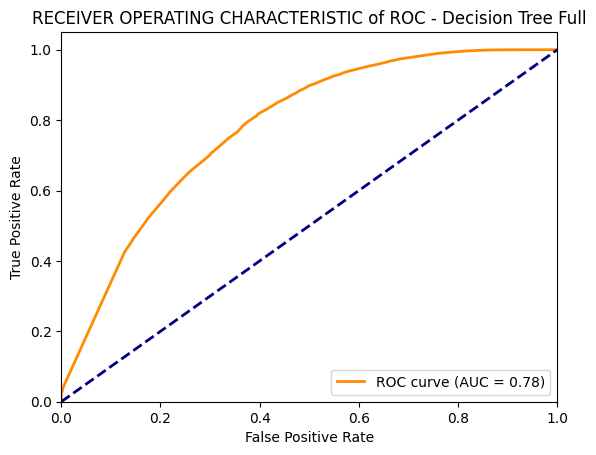

{'Sensitivity': 0.75,
 'Specificity': 0.66,
 'Accuracy': 0.69,
 'Matthews Correlation Coefficient (MCC)': 0.39,
 'Precision': 0.53,
 'Recall': 0.75,
 'F1 Score': 0.62}

In [ ]:
# Confusion matrix, Classification Report, Performance Metrics, ROC, and AUC
conf_matrix = confusion_matrix(y_test, y_pred)
sketch_confusion_matrix(y_test, y_pred, 'Confusion matrix - Decision Tree Full')
print('Classification Report:')
print(classification_report(y_test, y_pred))
plot_roc_curve(y_test, y_prob, 'ROC - Decision Tree Full')
get_performance_metrics(y_test, y_pred)

## Selected amino acid distribution

In [ ]:
# Fitting, prediction of labels for test, and probability of label 1
dt_clf.fit(X_train_selected, y_train_selected)

# Save model
save(dt_clf, "DT_Amino_Acid_Distribution_Selected")

y_pred = dt_clf.predict(X_test_selected)
y_prob = dt_clf.predict_proba(X_test_selected)[:, 1]

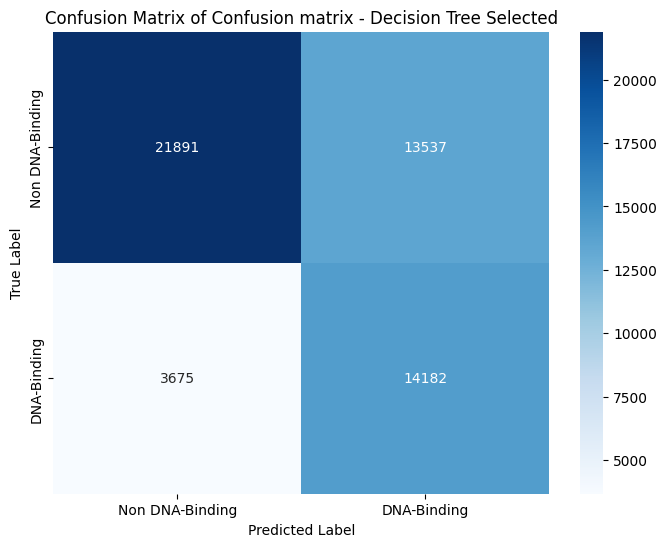

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.62      0.72     35428
           1       0.51      0.79      0.62     17857

    accuracy                           0.68     53285
   macro avg       0.68      0.71      0.67     53285
weighted avg       0.74      0.68      0.69     53285



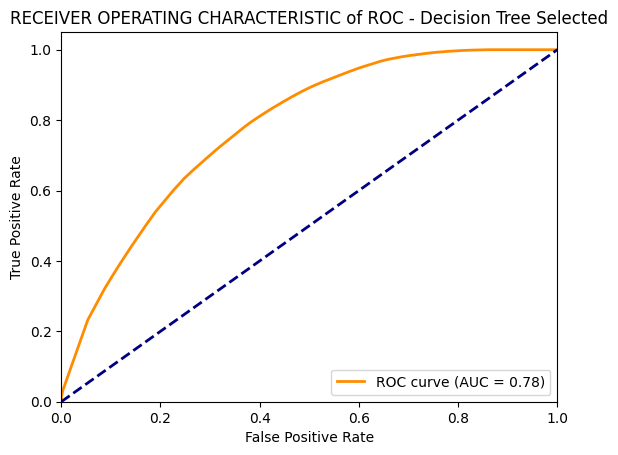

{'Sensitivity': 0.79,
 'Specificity': 0.62,
 'Accuracy': 0.68,
 'Matthews Correlation Coefficient (MCC)': 0.39,
 'Precision': 0.51,
 'Recall': 0.79,
 'F1 Score': 0.62}

In [ ]:
# Confusion matrix, Classification Report, Performance Metrics, ROC, and AUC
conf_matrix = confusion_matrix(y_test_selected, y_pred)
sketch_confusion_matrix(y_test_selected, y_pred, 'Confusion matrix - Decision Tree Selected')
print('Classification Report:')
print(classification_report(y_test_selected, y_pred))
plot_roc_curve(y_test_selected, y_prob, 'ROC - Decision Tree Selected')
get_performance_metrics(y_test_selected, y_pred)

# Random Forest


Random Forest classifier initiliaztion

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth=10, random_state=42)

## Random Forest for full amino acid distribution

In [ ]:
# Fitting, prediction of labels for test, and probability of label 1
rf_clf.fit(X_train, y_train)

# Save model
save(rf_clf, "RF_Amino_Acid_Distribution_Full")

y_pred = rf_clf.predict(X_test)
y_prob = rf_clf.predict_proba(X_test)[:, 1]

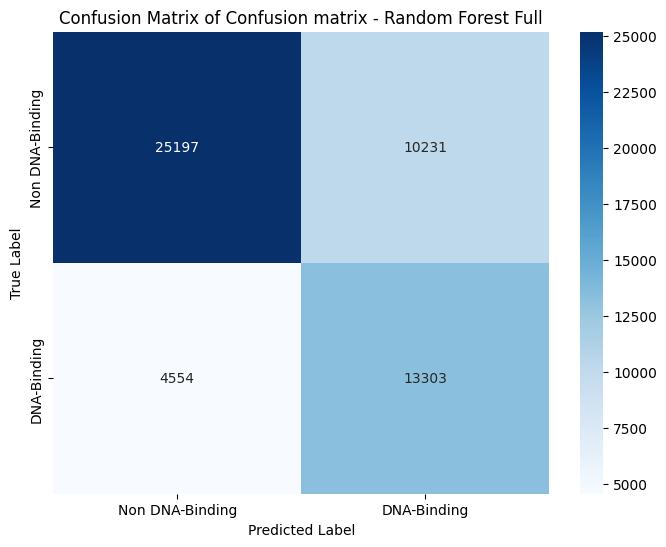

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.71      0.77     35428
           1       0.57      0.74      0.64     17857

    accuracy                           0.72     53285
   macro avg       0.71      0.73      0.71     53285
weighted avg       0.75      0.72      0.73     53285



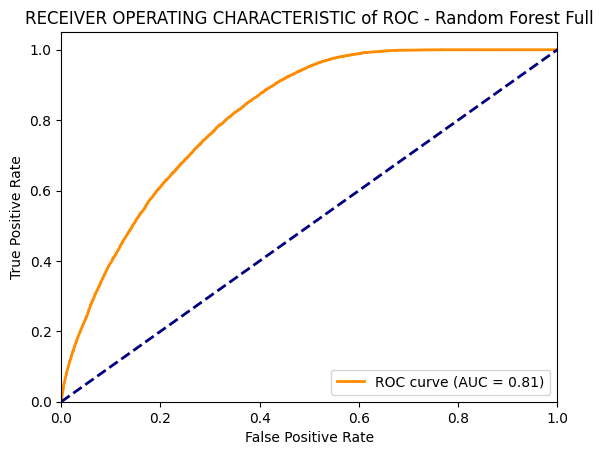

{'Sensitivity': 0.74,
 'Specificity': 0.71,
 'Accuracy': 0.72,
 'Matthews Correlation Coefficient (MCC)': 0.43,
 'Precision': 0.57,
 'Recall': 0.74,
 'F1 Score': 0.64}

In [ ]:
# Confusion matrix, Classification Report, Performance Metrics, ROC, and AUC
conf_matrix = confusion_matrix(y_test, y_pred)
sketch_confusion_matrix(y_test, y_pred, 'Confusion matrix - Random Forest Full')
print('Classification Report:')
print(classification_report(y_test, y_pred))
plot_roc_curve(y_test, y_prob, 'ROC - Random Forest Full')
get_performance_metrics(y_test, y_pred)

## Random tree forest for selected amino acids

In [ ]:
# Fitting, prediction of labels for test, and probability of label 1
rf_clf.fit(X_train_selected, y_train_selected)

# Save model
save(rf_clf, "RF_Amino_Acid_Distribution_Selected")

y_pred = rf_clf.predict(X_test_selected)
y_prob = rf_clf.predict_proba(X_test_selected)[:, 1]

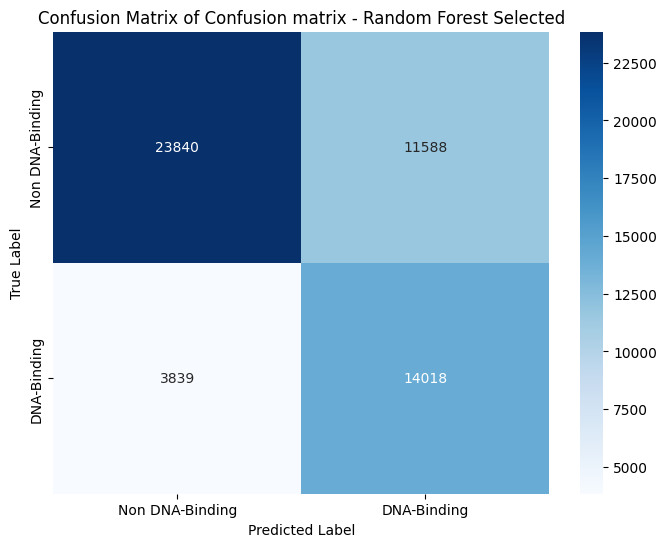

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.67      0.76     35428
           1       0.55      0.79      0.65     17857

    accuracy                           0.71     53285
   macro avg       0.70      0.73      0.70     53285
weighted avg       0.76      0.71      0.72     53285



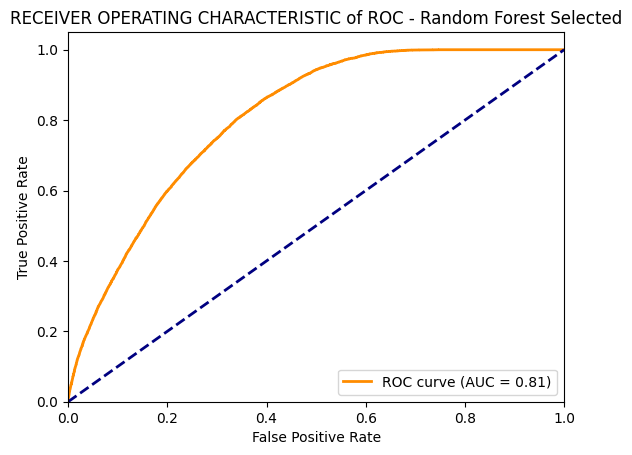

{'Sensitivity': 0.79,
 'Specificity': 0.67,
 'Accuracy': 0.71,
 'Matthews Correlation Coefficient (MCC)': 0.43,
 'Precision': 0.55,
 'Recall': 0.79,
 'F1 Score': 0.65}

In [ ]:
# Confusion matrix, Classification Report, Performance Metrics, ROC, and AUC
conf_matrix = confusion_matrix(y_test_selected, y_pred)
sketch_confusion_matrix(y_test_selected, y_pred, 'Confusion matrix - Random Forest Selected')
print('Classification Report:')
print(classification_report(y_test_selected, y_pred))
plot_roc_curve(y_test_selected, y_prob, 'ROC - Random Forest Selected')
get_performance_metrics(y_test_selected, y_pred)

# SVM


In [ ]:
# Initialize the SVM classifier
svc_clf = SVC(kernel='rbf',probability=True, random_state=42)

## SVM for the Full Amino Acid Distribution

In [ ]:
# Fitting, prediction of labels for test, and probability of label 1
svc_clf.fit(X_train, y_train)

# Save model
save(svc_clf, "SVM_Amino_Acid_Distribution_Full")

y_pred = svc_clf.predict(X_test)
y_prob = svc_clf.predict_proba(X_test)[:, 1]

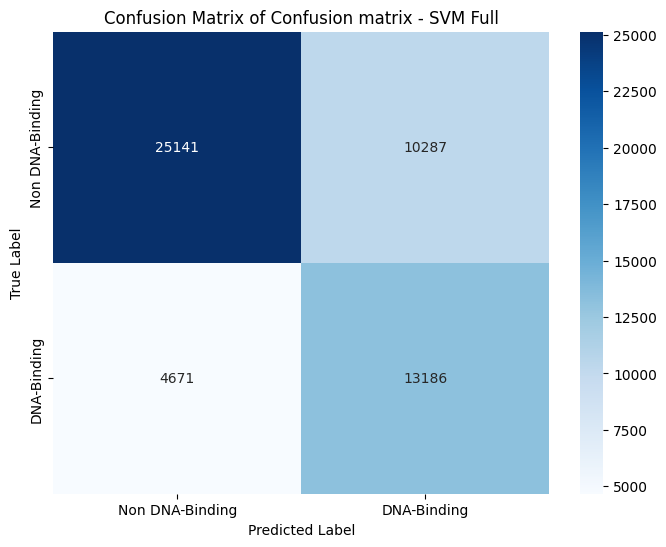

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.71      0.77     35428
           1       0.56      0.74      0.64     17857

    accuracy                           0.72     53285
   macro avg       0.70      0.72      0.70     53285
weighted avg       0.75      0.72      0.73     53285



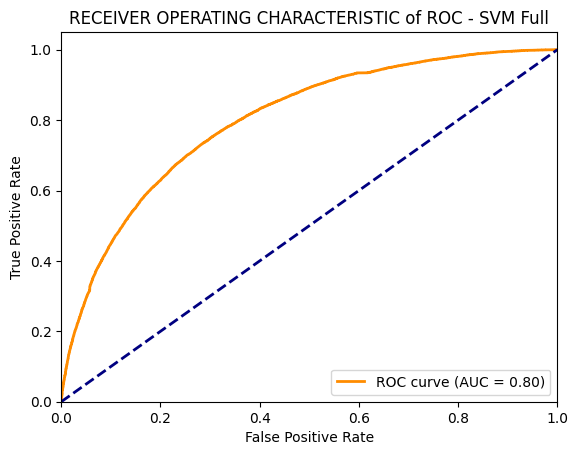

{'Sensitivity': 0.74,
 'Specificity': 0.71,
 'Accuracy': 0.72,
 'Matthews Correlation Coefficient (MCC)': 0.43,
 'Precision': 0.56,
 'Recall': 0.74,
 'F1 Score': 0.64}

In [ ]:
# Confusion matrix, Classification Report, Performance Metrics, ROC, and AUC
conf_matrix = confusion_matrix(y_test, y_pred)
sketch_confusion_matrix(y_test, y_pred, 'Confusion matrix - SVM Full')
print('Classification Report:')
print(classification_report(y_test, y_pred))
plot_roc_curve(y_test, y_prob, 'ROC - SVM Full')
get_performance_metrics(y_test, y_pred)

## SVM for selected Amino Acids

In [ ]:
# Fitting
svc_clf.fit(X_train_selected, y_train_selected)

# Save model
save(svc_clf, "SVM_Amino_Acid_Distribution_Selected")

# Prediction of labels for test, and probability of label 1
y_pred = svc_clf.predict(X_test_selected)
y_prob = svc_clf.predict_proba(X_test_selected)[:, 1]

In [ ]:
# Confusion matrix, Classification Report, Performance Metrics, ROC, and AUC
conf_matrix = confusion_matrix(y_test_selected, y_pred)
sketch_confusion_matrix(y_test_selected, y_pred, 'Confusion matrix - SVM Selected')
print('Classification Report:')
print(classification_report(y_test_selected, y_pred))
plot_roc_curve(y_test_selected, y_prob, 'ROC - SVM Selected')
get_performance_metrics(y_test_selected, y_pred)